# Overlapping genes in GENCODE

This notebook profile the overlapped genes in the GENCODE annotation.

In [44]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

In [37]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}
print("All transcripts: %d" % len(transcripts))

anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t")
for tid, ttype, gid, gtype, gname in anno[["TranscriptID", "TranscriptType", "GeneID", "GeneType", "GeneName"]].values:
    t = transcripts[tid]
    t.transcript_type = ttype
    t.gene_id = gid
    t.gene_type = gtype
    t.gene_name = gname
genes = []
data = defaultdict(list)
for t in transcripts.values():
    data[t.gene_id].append(t)
for gid, ts in data.items():
    g = GRange(chrom=ts[0].chrom, 
               start=min([t.start for t in ts]), 
               end=max([t.end for t in ts]), 
               strand=ts[0].strand, 
               name=gid)
    g.gene_name = ts[0].gene_name
    g.gene_type = ts[0].gene_type
    g.transcripts = ts
    genes.append(g)
print("All genes: %d" % len(genes))

genes = list(filter(lambda g: g.chrom != "chrM", genes))
print("Not chrM genes: %d" % len(genes))

genes = list(filter(lambda g: g.gene_type == "protein_coding", genes))
print("Protein coding genes: %d" % len(genes))

genes1 = list(filter(lambda g: g.gene_name.startswith("ENSG"), genes))
genes2 = list(filter(lambda g: not g.gene_name.startswith("ENSG"), genes))
print("Potential fusion genes: %d" % len(genes2))
print("Filtered genes: %d" % len(genes1))
genes = genes2

All transcripts: 244939
All genes: 61533
Not chrM genes: 61496
Protein coding genes: 19969
Potential fusion genes: 19375
Filtered genes: 594


Overlapped	Genes
0	13919
1	4434
2	814
3	133
4	13
5	5
6	3
8	9
9	2
10	3
11	1
13	1
14	15
16	1
21	22


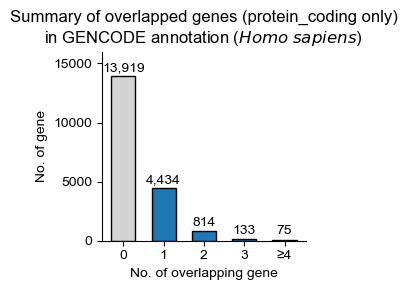

In [53]:
loader = ShiftLoader(genes)
for g1 in genes:
    overlap_genes = []
    for g2 in loader.fetch(obj=g1):
        if g2 is g1:
            continue
        overlap_genes.append(g2)
    g1.overlap_genes = overlap_genes

counter = Counter([len(g.overlap_genes) for g in genes])
print("Overlapped\tGenes")
for k, v in sorted(counter.items()):
    print(k, v, sep="\t")

N = 5
xs = np.arange(N)
ys = np.array([counter[x] for x in xs])
ticks = [str(x) for x in xs]
colors = ["C0"] * len(xs)
colors[0] = "lightgrey"
ys[-1] = sum(counter.values()) - sum(ys[:-1])
ticks[-1] = "≥%s" % ticks[-1]

plt.figure(figsize=(3, 3))
plt.title("Summary of overlapped genes (protein_coding only)\nin GENCODE annotation ($\it{Homo}$ $\it{sapiens}$)")
plt.bar(xs, ys, edgecolor="black", width=0.6, color=colors)
for x, y in zip(xs, ys):
    plt.text(x, y + 200, "%s" % format(y, ","), ha="center", va="bottom")
plt.ylim(0, 16000)
plt.xlabel("No. of overlapping gene")
plt.ylabel("No. of gene")
plt.xticks(xs, ticks)
for loc in ["top", "right"]:
    plt.gca().spines[loc].set_visible(False)
plt.tight_layout()
plt.savefig("figures/summary_of_overlap_genes.pdf")

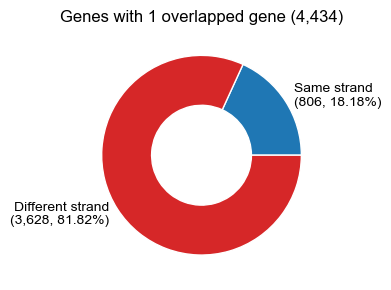

In [54]:
n1, n2 = 0, 0
for g in genes:
    if len(g.overlap_genes) == 1:
        g1 = g.overlap_genes[0]
        if g.strand == g1.strand:
            n1 += 1
        else:
            n2 += 1
plt.figure(figsize=(4, 3))
plt.title("Genes with 1 overlapped gene (%s)" % format(n1 + n2, ","))
plt.pie([n1, n2], pctdistance=0.75,
        colors=["C0", "C3"],
        wedgeprops=dict(width=0.5, edgecolor='w'),
        labels=[
            "Same strand\n(%s, %.2f%%)" % (format(n1, ","), n1*100/(n1+n2)), 
            "Different strand\n(%s, %.2f%%)" % (format(n2, ","), n2*100/(n1+n2))])
plt.tight_layout()
plt.savefig("figures/gene_pair_strands.pdf")